# Assignment 2 Week 2

In [1]:
import sys, os
from datetime import datetime, timedelta,date
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import json
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model

### Load Data

In [2]:
products_df = pd.read_csv('./../data/amazon_baby_subset.csv')

In [3]:
with open('./../data/important_words.json', 'r') as f: # Reads the list of most frequent words
    important_words = json.load(f)
important_words = [str(s) for s in important_words]

In [4]:
print('# of positive reviews =', len(products_df[products_df['sentiment']==1]))
print('# of negative reviews =', len(products_df[products_df['sentiment']==-1]))

# of positive reviews = 26579
# of negative reviews = 26493


In [5]:
products_df.review = products_df.review.fillna('')
products_df['reviews_clean'] = products_df.review.str.replace('[^\w\s]','').fillna('')
for word in important_words:
    products_df[word] = products_df['reviews_clean'].apply(lambda s : s.split().count(word))


In [6]:
train_indexes = pd.read_json('../data/module-4-assignment-train-idx.json')
val_indexes = pd.read_json('../data/module-4-assignment-validation-idx.json')

In [7]:
train_data = products_df.iloc[train_indexes[0].tolist()]
val_data = products_df.iloc[val_indexes[0].tolist()]

In [8]:
def get_numpy_data(data_frame, features, label):
    """
    features: list of feature columns
    label: str label columns name
    """
    data_frame['intercept'] = 1
    features = ['intercept'] + features
    features_frame = data_frame[features]
    feature_matrix = features_frame.as_matrix()
    label_frame  = data_frame[label]
    label_array = label_frame.as_matrix()
    return(feature_matrix, label_array)

In [9]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(val_data, important_words, 'sentiment')

/Users/nehiljain/.pyenv/versions/3.4.6/envs/py34/lib/python3.4/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    # YOUR CODE HERE
    scores = feature_matrix.dot(coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    # YOUR CODE HERE
    predictions = 1.0/(1.0 + np.exp(-scores))
    
    # return predictions
    return predictions

In [11]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    derivative = np.dot(errors, feature)
    if not feature_is_constant:
        derivative = np.dot(errors, feature) - 2 * l2_penalty * coefficient
    return derivative
    

In [12]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp

In [13]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        ## YOUR CODE HERE
        predictions = predict_probability(feature_matrix, coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            ## YOUR CODE HERE
            derivative = feature_derivative_with_L2(errors, feature_matrix[:, j], coefficients[j], l2_penalty, is_intercept)
            
            
            # add the step size times the derivative to the current coefficient
            ## YOUR CODE HERE
            coefficients[j] = coefficients[j] + step_size * derivative
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print('iteration %*d: log likelihood of observed labels = %.8f' % (int(np.ceil(np.log10(max_iter))), itr, lp))
    return coefficients

In [14]:
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros(194),
                                                     step_size=5e-6, l2_penalty=0, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.39021798
iteration   1: log likelihood of observed labels = -29003.71035760
iteration   2: log likelihood of observed labels = -28834.65864198
iteration   3: log likelihood of observed labels = -28671.70363804
iteration   4: log likelihood of observed labels = -28514.42569916
iteration   5: log likelihood of observed labels = -28362.47749087
iteration   6: log likelihood of observed labels = -28215.56033041
iteration   7: log likelihood of observed labels = -28073.40981663
iteration   8: log likelihood of observed labels = -27935.78694478
iteration   9: log likelihood of observed labels = -27802.47249034
iteration  10: log likelihood of observed labels = -27673.26336093
iteration  11: log likelihood of observed labels = -27547.97014376
iteration  12: log likelihood of observed labels = -27426.41538599
iteration  13: log likelihood of observed labels = -27308.43232975
iteration  14: log likelihood of observed labels = -27193.8639

In [15]:
coefficients_4_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=4, max_iter=501)
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=10, max_iter=501)
coefficients_1e2_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e2, max_iter=501)
coefficients_1e3_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e3, max_iter=501)


iteration   0: log likelihood of observed labels = -29179.39391674
iteration   1: log likelihood of observed labels = -29003.73193908
iteration   2: log likelihood of observed labels = -28834.71118800
iteration   3: log likelihood of observed labels = -28671.79927422
iteration   4: log likelihood of observed labels = -28514.57569763
iteration   5: log likelihood of observed labels = -28362.69234865
iteration   6: log likelihood of observed labels = -28215.84983345
iteration   7: log likelihood of observed labels = -28073.78309488
iteration   8: log likelihood of observed labels = -27936.25252111
iteration   9: log likelihood of observed labels = -27803.03832495
iteration  10: log likelihood of observed labels = -27673.93689203
iteration  11: log likelihood of observed labels = -27548.75832500
iteration  12: log likelihood of observed labels = -27427.32472103
iteration  13: log likelihood of observed labels = -27309.46890412
iteration  14: log likelihood of observed labels = -27195.0334

In [16]:

# run with L2 = 1e5
coefficients_1e5_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e5, max_iter=501)

iteration   0: log likelihood of observed labels = -29271.85898298
iteration   1: log likelihood of observed labels = -29271.70949208
iteration   2: log likelihood of observed labels = -29271.65681255
iteration   3: log likelihood of observed labels = -29271.61132176
iteration   4: log likelihood of observed labels = -29271.57022075
iteration   5: log likelihood of observed labels = -29271.53300467
iteration   6: log likelihood of observed labels = -29271.49930278
iteration   7: log likelihood of observed labels = -29271.46878310
iteration   8: log likelihood of observed labels = -29271.44114515
iteration   9: log likelihood of observed labels = -29271.41611682
iteration  10: log likelihood of observed labels = -29271.39345172
iteration  11: log likelihood of observed labels = -29271.37292669
iteration  12: log likelihood of observed labels = -29271.35433968
iteration  13: log likelihood of observed labels = -29271.33750769
iteration  14: log likelihood of observed labels = -29271.3222

In [19]:
coeff_df = pd.DataFrame({'word': ['intercept'] + important_words})

In [20]:
def add_coeff_column(df, coeff, column_name):
    df[column_name] = coeff
    return df

In [21]:
coeff_df = add_coeff_column(coeff_df, coefficients_0_penalty, 'coefficients_L2_0')
coeff_df = add_coeff_column(coeff_df, coefficients_4_penalty, 'coefficients_L2_4')
coeff_df = add_coeff_column(coeff_df, coefficients_10_penalty, 'coefficients_L2_10')
coeff_df = add_coeff_column(coeff_df, coefficients_1e2_penalty, 'coefficients_L2_1e2')
coeff_df = add_coeff_column(coeff_df, coefficients_1e3_penalty, 'coefficients_L2_1e3')
coeff_df = add_coeff_column(coeff_df, coefficients_1e5_penalty, 'coefficients_L2_1e5')

In [22]:
coeff_df.head()

,word,coefficients_L2_0,coefficients_L2_4,coefficients_L2_10,coefficients_L2_1e2,coefficients_L2_1e3,coefficients_L2_1e5
0,intercept,-0.063729,-0.063130,-0.062243,-0.050427,0.000060,0.011362
1,baby,0.074055,0.073976,0.073859,0.072344,0.059745,0.001784
2,one,0.012740,0.012482,0.012103,0.007235,-0.008766,-0.001827
3,great,0.801614,0.796886,0.789924,0.701416,0.376009,0.008950
4,love,1.058595,1.050897,1.039569,0.896676,0.418361,0.009042


In [36]:
top_negative_words = coeff_df.sort_values(by='coefficients_L2_0').head()[['word']]
top_negative_features = top_negative_words.word.tolist()

In [46]:
top_positive_features = coeff_df.sort_values(by='coefficients_L2_0').tail()[['word']]
top_positive_features = list(reversed(top_positive_features.word.tolist()))

In [47]:
top_negative_features

['disappointed', 'money', 'return', 'waste', 'returned']

In [48]:
top_positive_features

['love', 'loves', 'easy', 'perfect', 'great']

In [57]:
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(df, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    positive_words_df = df[df.word.isin(positive_words)]
    negative_words_df = df[df.word.isin(negative_words)]
    del positive_words_df['word']
    del negative_words_df['word']
    
    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, positive_words_df[i:i+1].as_matrix().flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, negative_words_df[i:i+1].as_matrix().flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()

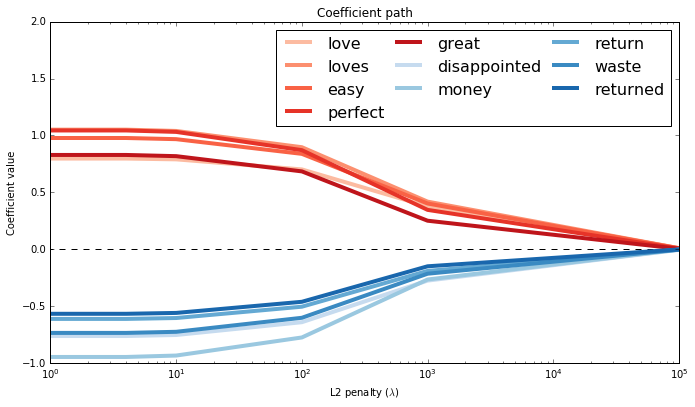

In [58]:
make_coefficient_plot(coeff_df, top_positive_features, top_negative_features, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

In [67]:
def get_classification_accuracy(feature_matrix, sentiment, coefficients):
    scores = np.dot(feature_matrix, coefficients)
    apply_threshold = np.vectorize(lambda x: 1. if x > 0  else -1.)
    predictions = apply_threshold(scores)
    
    num_correct = (predictions == sentiment).sum()
    accuracy = num_correct / len(feature_matrix)    
    return round(accuracy, 4)

In [68]:
train_accuracy = {}
train_accuracy['l2_0']   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_0_penalty)
train_accuracy['l2_4']   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_4_penalty)
train_accuracy['l2_10']  = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_10_penalty)
train_accuracy['l2_1e2'] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e2_penalty)
train_accuracy['l2_1e3'] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e3_penalty)
train_accuracy['l2_1e5'] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e5_penalty)

validation_accuracy = {}
validation_accuracy['l2_0']   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_0_penalty)
validation_accuracy['l2_4']   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_4_penalty)
validation_accuracy['l2_10']  = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_10_penalty)
validation_accuracy['l2_1e2'] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e2_penalty)
validation_accuracy['l2_1e3'] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e3_penalty)
validation_accuracy['l2_1e5'] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e5_penalty)

In [69]:
# Build a simple report
for key in sorted(validation_accuracy.keys()):
    print("L2 penalty = %s" % key)
    print("train accuracy = %s, validation_accuracy = %s" % (train_accuracy[key], validation_accuracy[key]))
    print("--------------------------------------------------------------------------------")

L2 penalty = l2_0
train accuracy = 0.7852, validation_accuracy = 0.7813
--------------------------------------------------------------------------------
L2 penalty = l2_10
train accuracy = 0.785, validation_accuracy = 0.7817
--------------------------------------------------------------------------------
L2 penalty = l2_1e2
train accuracy = 0.784, validation_accuracy = 0.7811
--------------------------------------------------------------------------------
L2 penalty = l2_1e3
train accuracy = 0.7758, validation_accuracy = 0.7714
--------------------------------------------------------------------------------
L2 penalty = l2_1e5
train accuracy = 0.6803, validation_accuracy = 0.6678
--------------------------------------------------------------------------------
L2 penalty = l2_4
train accuracy = 0.7851, validation_accuracy = 0.7815
--------------------------------------------------------------------------------


In [70]:
print("Highest accuract on Training Set is L2=0")

Highest accuract on Training Set is L2=0


In [71]:
print("Highest accuract on Validation Set is L2=10")

Highest accuract on Validation Set is L2=10
